In [48]:
# Imports here
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import random
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms 
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter 
from tqdm import tqdm

from PIL import Image
import json
from matplotlib.ticker import FormatStrFormatter

In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# **Steps**

Step 1: Load Dataset <p>
Step 2: Transform the Dataset <p>
Step 3: Create Model <p>
Step 4: Train Model <p>
Step 5: Save the Model <p>
Step 6: Load the Model <p>

# Step 1: Load Dataset

In [50]:
data_dir = './dataset'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

# Step 2: Transform the Dataset

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's [0.485, 0.456, 0.406] and for the standard deviations [0.229, 0.224, 0.225], calculated from the ImageNet images. These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [51]:
# Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])


trainset = torchvision.datasets.ImageFolder(root=train_dir, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=0)

testset = torchvision.datasets.ImageFolder(root=valid_dir, transform=test_transforms)
validloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)

# Step 3: Create Model

In [52]:
class TransferLearningModel(nn.Module):
    def __init__(self):
        super(TransferLearningModel, self).__init__()
        # Use a pre-trained model as the convolutional base
        self.resnet = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(self.resnet.children())[:-1])
        
        # New fully connected layers for classification
        self.fc1 = nn.Linear(2048, 512)  # Adjusted to match ResNet50's output
        self.fc2 = nn.Linear(512, 102)   # Assuming 102 classes for classification
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Pass input through the pre-trained model's convolutional layers
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [53]:
model = TransferLearningModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) #set to ADAM

In [54]:
# Model instantiation and dummy input
model_test = TransferLearningModel()
input_test = torch.randn(64, 3, 224, 224)  # Random input tensor

# Forward pass
output_test = model_test(input_test)
print(output_test.shape)

torch.Size([64, 102])


# Step 4: Train Model

In [55]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import numpy as np
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import pandas as pd

# Assuming the following variables are defined and initialized appropriately:
# model, criterion, optimizer, trainloader, validloader, device, etc.

num_epochs = 100

# Initialize lists to store losses and accuracies
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

# Initialize early stopping parameters
best_val_loss = np.Inf
patience = 5
patience_counter = 0

writer = SummaryWriter()

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for data in tqdm(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")
    
    # Validation Phase
    model.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    
    with torch.no_grad():
        for inputs, labels in validloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    valid_accuracy = 100 * correct_valid / total_valid
    valid_losses.append(valid_loss / len(validloader))
    valid_accuracies.append(valid_accuracy)
    
    current_val_loss = valid_loss / len(validloader)
    print(f"Validation Loss: {current_val_loss:.4f}, Validation Accuracy: {valid_accuracy:.2f}%")
    
    # Early Stopping
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}. Best validation loss: {best_val_loss:.4f}")
            break

# After the training loop
df = pd.DataFrame({
    'Epoch': range(1, len(train_losses) + 1),
    'Training Loss': train_losses,
    'Training Accuracy': train_accuracies,
    'Validation Loss': valid_losses,
    'Validation Accuracy': valid_accuracies
})

csv_file = 'training_data.csv'
df.to_csv(csv_file, index=False)

print(f'Training data saved to {csv_file}')


100%|██████████| 205/205 [01:31<00:00,  2.24it/s]


Epoch 1/100, Training Loss: 4.1011, Training Accuracy: 7.69%
Validation Loss: 3.5588, Validation Accuracy: 13.33%


100%|██████████| 205/205 [01:24<00:00,  2.43it/s]


Epoch 2/100, Training Loss: 3.4801, Training Accuracy: 13.80%
Validation Loss: 3.1787, Validation Accuracy: 17.85%


100%|██████████| 205/205 [01:25<00:00,  2.41it/s]


Epoch 3/100, Training Loss: 3.1295, Training Accuracy: 20.05%
Validation Loss: 2.8195, Validation Accuracy: 25.67%


100%|██████████| 205/205 [01:24<00:00,  2.43it/s]


Epoch 4/100, Training Loss: 2.8250, Training Accuracy: 25.50%
Validation Loss: 2.3817, Validation Accuracy: 33.74%


100%|██████████| 205/205 [01:24<00:00,  2.41it/s]


Epoch 5/100, Training Loss: 2.5887, Training Accuracy: 30.54%
Validation Loss: 2.1219, Validation Accuracy: 40.10%


100%|██████████| 205/205 [01:24<00:00,  2.42it/s]


Epoch 6/100, Training Loss: 2.4286, Training Accuracy: 34.33%
Validation Loss: 2.1436, Validation Accuracy: 39.73%


100%|██████████| 205/205 [01:24<00:00,  2.44it/s]


Epoch 7/100, Training Loss: 2.3061, Training Accuracy: 37.77%
Validation Loss: 1.8968, Validation Accuracy: 47.07%


100%|██████████| 205/205 [01:24<00:00,  2.43it/s]


Epoch 8/100, Training Loss: 2.1299, Training Accuracy: 41.47%
Validation Loss: 1.7802, Validation Accuracy: 48.53%


100%|██████████| 205/205 [01:24<00:00,  2.42it/s]


Epoch 9/100, Training Loss: 1.9959, Training Accuracy: 45.36%
Validation Loss: 1.7483, Validation Accuracy: 50.73%


100%|██████████| 205/205 [01:23<00:00,  2.46it/s]


Epoch 10/100, Training Loss: 1.8742, Training Accuracy: 48.50%
Validation Loss: 1.5989, Validation Accuracy: 52.81%


100%|██████████| 205/205 [01:23<00:00,  2.44it/s]


Epoch 11/100, Training Loss: 1.7635, Training Accuracy: 50.84%
Validation Loss: 1.3038, Validation Accuracy: 63.94%


100%|██████████| 205/205 [01:24<00:00,  2.43it/s]


Epoch 12/100, Training Loss: 1.6274, Training Accuracy: 54.27%
Validation Loss: 1.2734, Validation Accuracy: 65.28%


100%|██████████| 205/205 [01:24<00:00,  2.43it/s]


Epoch 13/100, Training Loss: 1.5522, Training Accuracy: 56.61%
Validation Loss: 1.3524, Validation Accuracy: 62.96%


100%|██████████| 205/205 [01:24<00:00,  2.43it/s]


Epoch 14/100, Training Loss: 1.4629, Training Accuracy: 58.65%
Validation Loss: 1.4675, Validation Accuracy: 61.74%


100%|██████████| 205/205 [01:24<00:00,  2.42it/s]


Epoch 15/100, Training Loss: 1.3837, Training Accuracy: 60.79%
Validation Loss: 1.1062, Validation Accuracy: 70.42%


100%|██████████| 205/205 [01:24<00:00,  2.42it/s]


Epoch 16/100, Training Loss: 1.3095, Training Accuracy: 63.54%
Validation Loss: 0.9255, Validation Accuracy: 74.57%


100%|██████████| 205/205 [01:24<00:00,  2.44it/s]


Epoch 17/100, Training Loss: 1.2443, Training Accuracy: 64.93%
Validation Loss: 0.8499, Validation Accuracy: 77.26%


100%|██████████| 205/205 [01:24<00:00,  2.42it/s]


Epoch 18/100, Training Loss: 1.1821, Training Accuracy: 66.44%
Validation Loss: 0.9266, Validation Accuracy: 75.92%


100%|██████████| 205/205 [01:25<00:00,  2.40it/s]


Epoch 19/100, Training Loss: 1.1425, Training Accuracy: 67.26%
Validation Loss: 0.7350, Validation Accuracy: 80.68%


100%|██████████| 205/205 [01:23<00:00,  2.45it/s]


Epoch 20/100, Training Loss: 1.1214, Training Accuracy: 68.99%
Validation Loss: 0.7504, Validation Accuracy: 80.20%


100%|██████████| 205/205 [01:24<00:00,  2.42it/s]


Epoch 21/100, Training Loss: 1.0295, Training Accuracy: 71.52%
Validation Loss: 0.7553, Validation Accuracy: 80.68%


100%|██████████| 205/205 [01:23<00:00,  2.45it/s]


Epoch 22/100, Training Loss: 0.9924, Training Accuracy: 71.64%
Validation Loss: 0.6819, Validation Accuracy: 81.30%


100%|██████████| 205/205 [01:27<00:00,  2.36it/s]


Epoch 23/100, Training Loss: 0.9516, Training Accuracy: 73.28%
Validation Loss: 0.6495, Validation Accuracy: 83.50%


100%|██████████| 205/205 [01:24<00:00,  2.43it/s]


Epoch 24/100, Training Loss: 0.9226, Training Accuracy: 73.31%
Validation Loss: 0.5595, Validation Accuracy: 84.23%


100%|██████████| 205/205 [01:24<00:00,  2.42it/s]


Epoch 25/100, Training Loss: 0.9012, Training Accuracy: 74.53%
Validation Loss: 0.5606, Validation Accuracy: 85.94%


100%|██████████| 205/205 [01:25<00:00,  2.41it/s]


Epoch 26/100, Training Loss: 0.9200, Training Accuracy: 73.29%
Validation Loss: 0.5297, Validation Accuracy: 85.45%


100%|██████████| 205/205 [01:24<00:00,  2.43it/s]


Epoch 27/100, Training Loss: 0.8026, Training Accuracy: 77.35%
Validation Loss: 0.5419, Validation Accuracy: 84.35%


100%|██████████| 205/205 [01:24<00:00,  2.44it/s]


Epoch 28/100, Training Loss: 0.8114, Training Accuracy: 77.53%
Validation Loss: 0.4893, Validation Accuracy: 88.14%


100%|██████████| 205/205 [01:24<00:00,  2.43it/s]


Epoch 29/100, Training Loss: 0.7872, Training Accuracy: 77.64%
Validation Loss: 0.5145, Validation Accuracy: 86.06%


100%|██████████| 205/205 [01:26<00:00,  2.37it/s]


Epoch 30/100, Training Loss: 0.7708, Training Accuracy: 78.17%
Validation Loss: 0.4467, Validation Accuracy: 87.04%


100%|██████████| 205/205 [01:24<00:00,  2.43it/s]


Epoch 31/100, Training Loss: 0.7307, Training Accuracy: 79.35%
Validation Loss: 0.4753, Validation Accuracy: 87.65%


100%|██████████| 205/205 [01:24<00:00,  2.43it/s]


Epoch 32/100, Training Loss: 0.7217, Training Accuracy: 79.70%
Validation Loss: 0.4662, Validation Accuracy: 89.49%


100%|██████████| 205/205 [01:23<00:00,  2.45it/s]


Epoch 33/100, Training Loss: 0.7026, Training Accuracy: 80.39%
Validation Loss: 0.4909, Validation Accuracy: 87.65%


100%|██████████| 205/205 [01:24<00:00,  2.44it/s]


Epoch 34/100, Training Loss: 0.6931, Training Accuracy: 79.81%
Validation Loss: 0.4102, Validation Accuracy: 89.36%


100%|██████████| 205/205 [01:23<00:00,  2.44it/s]


Epoch 35/100, Training Loss: 0.6737, Training Accuracy: 80.69%
Validation Loss: 0.4572, Validation Accuracy: 89.12%


100%|██████████| 205/205 [01:23<00:00,  2.47it/s]


Epoch 36/100, Training Loss: 0.6687, Training Accuracy: 80.98%
Validation Loss: 0.4980, Validation Accuracy: 87.90%


100%|██████████| 205/205 [01:23<00:00,  2.45it/s]


Epoch 37/100, Training Loss: 0.6299, Training Accuracy: 82.22%
Validation Loss: 0.4806, Validation Accuracy: 88.39%


100%|██████████| 205/205 [01:24<00:00,  2.44it/s]


Epoch 38/100, Training Loss: 0.6330, Training Accuracy: 82.51%
Validation Loss: 0.5228, Validation Accuracy: 88.88%


100%|██████████| 205/205 [01:23<00:00,  2.44it/s]


Epoch 39/100, Training Loss: 0.6104, Training Accuracy: 82.95%
Validation Loss: 0.3924, Validation Accuracy: 89.85%


100%|██████████| 205/205 [01:24<00:00,  2.42it/s]


Epoch 40/100, Training Loss: 0.5976, Training Accuracy: 83.15%
Validation Loss: 0.4476, Validation Accuracy: 89.00%


100%|██████████| 205/205 [01:23<00:00,  2.46it/s]


Epoch 41/100, Training Loss: 0.5834, Training Accuracy: 83.50%
Validation Loss: 0.4686, Validation Accuracy: 88.63%


100%|██████████| 205/205 [01:23<00:00,  2.46it/s]


Epoch 42/100, Training Loss: 0.5450, Training Accuracy: 84.46%
Validation Loss: 0.4128, Validation Accuracy: 90.34%


100%|██████████| 205/205 [01:23<00:00,  2.46it/s]


Epoch 43/100, Training Loss: 0.5485, Training Accuracy: 84.45%
Validation Loss: 0.4692, Validation Accuracy: 89.00%


100%|██████████| 205/205 [01:25<00:00,  2.39it/s]


Epoch 44/100, Training Loss: 0.5547, Training Accuracy: 83.96%
Validation Loss: 0.3850, Validation Accuracy: 90.59%


100%|██████████| 205/205 [01:24<00:00,  2.43it/s]


Epoch 45/100, Training Loss: 0.5618, Training Accuracy: 84.40%
Validation Loss: 0.3705, Validation Accuracy: 91.44%


100%|██████████| 205/205 [01:24<00:00,  2.43it/s]


Epoch 46/100, Training Loss: 0.5281, Training Accuracy: 84.95%
Validation Loss: 0.3994, Validation Accuracy: 90.83%


100%|██████████| 205/205 [01:24<00:00,  2.43it/s]


Epoch 47/100, Training Loss: 0.5292, Training Accuracy: 85.20%
Validation Loss: 0.4367, Validation Accuracy: 89.36%


100%|██████████| 205/205 [01:23<00:00,  2.45it/s]


Epoch 48/100, Training Loss: 0.5121, Training Accuracy: 85.59%
Validation Loss: 0.4799, Validation Accuracy: 87.53%


100%|██████████| 205/205 [01:25<00:00,  2.38it/s]


Epoch 49/100, Training Loss: 0.5147, Training Accuracy: 85.49%
Validation Loss: 0.3673, Validation Accuracy: 92.18%


100%|██████████| 205/205 [01:25<00:00,  2.40it/s]


Epoch 50/100, Training Loss: 0.5089, Training Accuracy: 85.13%
Validation Loss: 0.3695, Validation Accuracy: 91.20%


100%|██████████| 205/205 [01:26<00:00,  2.37it/s]


Epoch 51/100, Training Loss: 0.4874, Training Accuracy: 86.75%
Validation Loss: 0.4600, Validation Accuracy: 90.46%


100%|██████████| 205/205 [01:23<00:00,  2.45it/s]


Epoch 52/100, Training Loss: 0.5124, Training Accuracy: 85.91%
Validation Loss: 0.3701, Validation Accuracy: 91.44%


100%|██████████| 205/205 [01:23<00:00,  2.45it/s]


Epoch 53/100, Training Loss: 0.4804, Training Accuracy: 86.22%
Validation Loss: 0.3941, Validation Accuracy: 91.44%


100%|██████████| 205/205 [01:24<00:00,  2.42it/s]


Epoch 54/100, Training Loss: 0.4789, Training Accuracy: 86.22%
Validation Loss: 0.3944, Validation Accuracy: 91.81%
Early stopping triggered at epoch 54. Best validation loss: 0.3673
Training data saved to training_data.csv


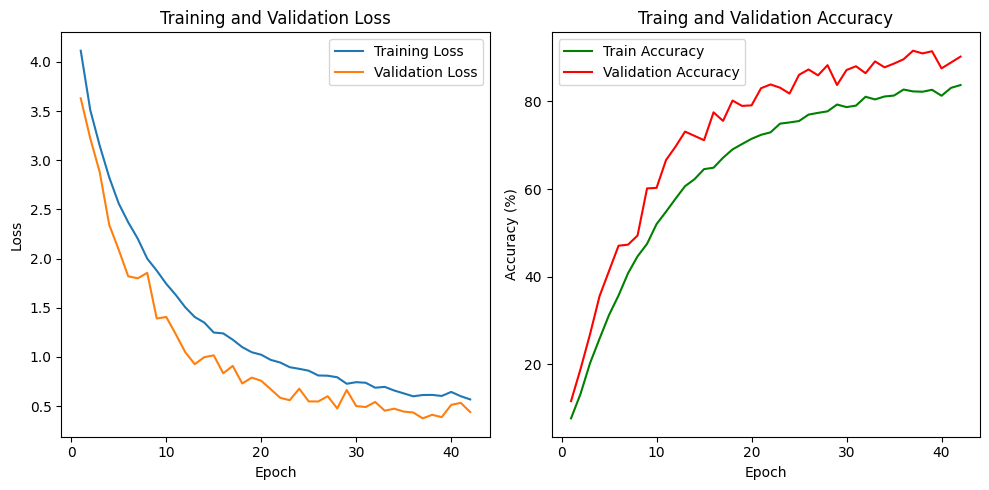

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data from the CSV file
csv_file = 'transfer_learning_data_retest.csv'
df = pd.read_csv(csv_file)

# Extract the data from the DataFrame
epoch = df['Epoch']
train_losses = df['Training Loss']
valid_losses = df['Validation Loss']
train_accuracies = df['Training Accuracy']
valid_accuracies = df['Validation Accuracy']

# Create subplots
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epoch, train_losses, label='Training Loss')
plt.plot(epoch, valid_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epoch, train_accuracies, label='Train Accuracy', color='green')
plt.plot(epoch, valid_accuracies, label='Validation Accuracy', color='red')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Traing and Validation Accuracy')

plt.tight_layout()
plt.show()

In [65]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
  for support_set, query_set in validloader:
      support_set, query_set = support_set.to(device), query_set.to(device)
      embeddings = model(support_set)
      _, predicted = torch.max(embeddings, 1)
      total += query_set.size(0)
      correct += (predicted == query_set).sum().item()
print('Accuracy: %d %%' % (100 * correct / total))

Accuracy: 91 %


# Step 5: Save the Model

In [66]:
# Save the trained model to a file
torch.save(model,'Models/transfer_learning_model_retest_dict.pth')

In [59]:
model = TransferLearningModel()  # Instantiate your model class
model = torch.load('Models/transfer_learning_model_retest_dict.pth')  # Load the model's state_dict

model.to(device)  # Move the model to the specified device


# Switch the model to evaluation mode
model.eval()


c:\Users\yeotz\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yeotz\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TransferLearningModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Raw Model Output: tensor([[ -5.1354, -10.2204, -17.8570,  -9.0571, -15.3433,  -3.3446, -11.0693,
          -7.8494,  -8.9386, -18.6205, -11.5055, -11.1106,  -5.2967,  -9.6469,
          -5.4538,  -7.5066, -12.1470,  -8.0294,  -3.4036,  -7.4289,  -9.9725,
          -8.4770, -14.7488,  -8.8969,  -6.1174,  -2.8179,  -3.6332,   0.3277,
          -4.0733,  -6.3788,  -8.7433, -12.5199,  -5.6089,  -5.9513,  -7.6670,
          -3.3254,  -1.6146,  -6.1394,  -6.5383,  -7.1315,   0.3283,  -3.8006,
          -4.4456, -10.0655, -15.6713, -19.4288, -11.0814, -18.2576, -19.9562,
          -3.5796, -10.9759,  -7.1719, -20.4934,  -7.8606, -10.2385,  -8.1406,
         -12.7089, -16.3266, -14.9027,  -8.2661, -11.8068,  -9.1119, -22.1868,
         -10.8521,  -8.9021, -16.6809,  -7.7149,  -5.0179, -13.4392,  -3.4660,
          -4.2092, -21.1432,  -2.2009,  -3.5804,  -1.9600,  -2.8684,  -5.9699,
         -10.1743,  -4.2590, -17.7125, -14.1676,  -4.1982,  -9.8597,  -4.9984,
          -6.0322,  -3.5901,  -5.5

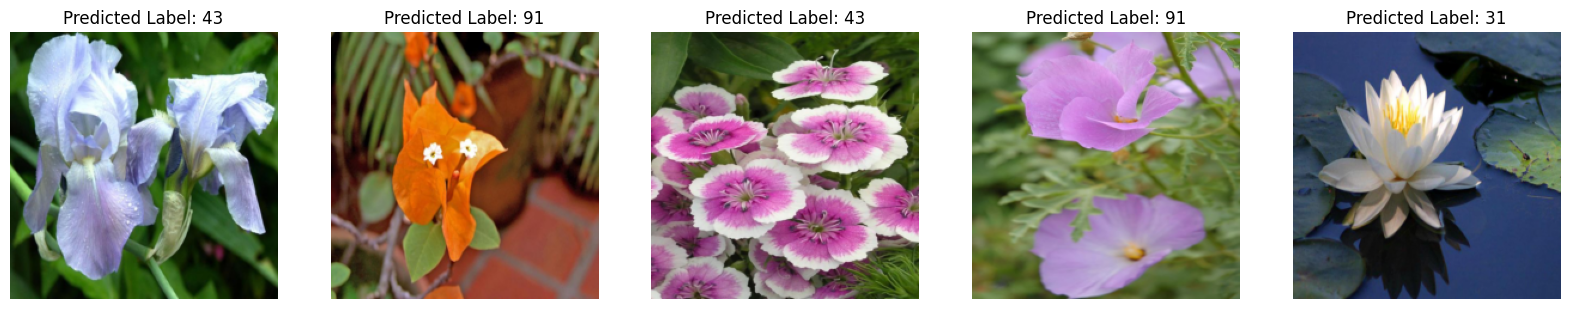

In [73]:
import os
import random
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
model.eval()

# Define the directory path for the test images
test_dir = 'dataset/test'

# List all the image files in the test directory
image_files = [os.path.join(test_dir, filename) for filename in os.listdir(test_dir) if filename.endswith(('.jpg', '.png', '.jpeg'))]

# Randomly select 5 images
random_images = random.sample(image_files, 5)

# Create a subplot with 1 row and 5 columns
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

# Symbol mapping
Symbol_Map_to_id = {
    0: "1",
    1: "10",
    2: "100",
    3: "101",
    4: "102",
    5: "11",
    6: "12",
    7: "13",
    8: "14",
    9: "15",
    10: "16",
    11: "17",
    12: "18",
    13: "19",
    14: "2",
    15: "20",
    16: "21",
    17: "22",
    18: "23",
    19: "24",
    20: "25",
    21: "26",
    22: "27",
    23: "28",
    24: "29",
    25: "3",
    26: "30",
    27: "31",
    28: "32",
    29: "33",
    30: "34",
    31: "35",
    32: "36",
    33: "37",
    34: "38",
    35: "39",
    36: "4",
    37: "40",
    38: "41",
    39: "42",
    40: "43",
    41: "44",
    42: "45",
    43: "46",
    44: "47",
    45: "48",
    46: "49",
    47: "5",
    48: "50",
    49: "51",
    50: "52",
    51: "53",
    52: "54",
    53: "55",
    54: "56",
    55: "57",
    56: "58",
    57: "59",
    58: "6",
    59: "60",
    60: "61",
    61: "62",
    62: "63",
    63: "64",
    64: "65",
    65: "66",
    66: "67",
    67: "68",
    68: "69",
    69: "7",
    70: "70",
    71: "71",
    72: "72",
    73: "73",
    74: "74",
    75: "75",
    76: "76",
    77: "77",
    78: "78",
    79: "79",
    80: "8",
    81: "80",
    82: "81",
    83: "82",
    84: "83",
    85: "84",
    86: "85",
    87: "86",
    88: "87",
    89: "88",
    90: "89",
    91: "9",
    92: "90",
    93: "91",
    94: "92",
    95: "93",
    96: "94",
    97: "95",
    98: "96",
    99: "97",
    100: "98",
    101: "99"
}

# You need to define the 'transform' for preprocessing images and the 'device' for the model.
# Make sure to load your model before using it.

# Example transform:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Example device:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to display an image with its predicted class
# Function to display an image with its predicted class
def display_image(image_path, ax):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)  # Apply the same transformations

    # Load your model here and define it as 'model'
    model.eval()
    with torch.no_grad():
        output = model(image)

    with torch.no_grad():
        output = model(image)
        print(f'Raw Model Output: {output}')


    _, predicted_class = output.max(1)
    predicted_numeric_label = predicted_class.item()

    # Get the raw model prediction (numeric label) before mapping
    raw_prediction = predicted_numeric_label

    # Convert the predicted numeric label to the lexicographic string using the Symbol_Map_to_id dictionary
    predicted_lexicographic_label = Symbol_Map_to_id.get(predicted_numeric_label, 'Unknown')

    image = image.cpu()
    ax.imshow(np.array(image.squeeze().permute(1, 2, 0)))
    ax.set_title(f'Predicted Label: {predicted_lexicographic_label}')
    ax.axis('off')

    print(f'Raw Prediction (Numeric Label): {raw_prediction}')
    print(f'Predicted Label: {predicted_lexicographic_label}')

# Display the randomly selected images side by side
for i, image_path in enumerate(random_images):
    display_image(image_path, axes[i])

plt.show()

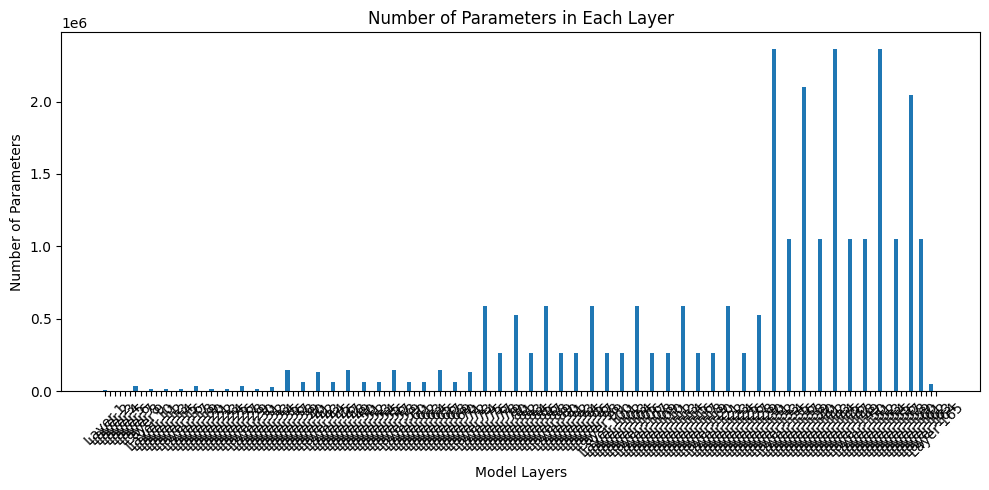

In [62]:
# Get the model's parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = [p.numel() for p in model_parameters]

# Create labels for each layer
layer_labels = [f'Layer {i}' for i in range(1, len(params) + 1)]

# Create a bar graph
plt.figure(figsize=(10, 5))
plt.bar(layer_labels, params)
plt.xlabel('Model Layers')
plt.ylabel('Number of Parameters')
plt.title('Number of Parameters in Each Layer')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the graph
plt.show()

In [63]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Set the model to evaluation mode
model.eval()

# Initialize variables to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation dataset to collect labels
with torch.no_grad():
    for images, labels in validloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Convert the confusion matrix to a Pandas DataFrame for visualization
cm_df = pd.DataFrame(cm, index=cat_to_name.values(), columns=cat_to_name.values())

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

NameError: name 'cat_to_name' is not defined

In [ ]:
writer.close()

In [ ]:
tensorboard --logdir==runs